pre-trained on imagenet by keras.applications

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/MyDrive/Challenge1/
dataset_dir = 'training_data_final'

Mounted at /gdrive
/gdrive/MyDrive/Challenge1


In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers

In [ ]:
# Random seed for reproducibility
seed = 127
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('model_14_11_vgg16_global')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch = 32


data_gen = ImageDataGenerator(validation_split=0.15,
                              rotation_range=10,
                              height_shift_range=10,
                              width_shift_range=10,
                              zoom_range=0.15,
                              horizontal_flip=True,
                              vertical_flip=True, 
                              fill_mode='reflect',
                              preprocessing_function = tf.keras.applications.vgg16.preprocess_input) #PREPROCESS FOR vgg16)

train_gen = data_gen.flow_from_directory(directory=dataset_dir,
                                                           target_size=(96,96),
                                                           color_mode='rgb',
                                                           classes=None,
                                                           class_mode='categorical',
                                                           batch_size=batch,
                                                           shuffle=True,
                                                           seed=seed,
                                                           subset='training') # set as training data

val_gen = data_gen.flow_from_directory(directory=dataset_dir,
                                                           target_size=(96,96),
                                                           color_mode='rgb',
                                                           classes=None,
                                                           class_mode='categorical',
                                                           batch_size=batch,
                                                           shuffle=True,
                                                           seed=seed,
                                                           subset='validation') # set as validation data

Found 3015 images belonging to 8 classes.
Found 527 images belonging to 8 classes.


In [ ]:
# Download and plot the VGG16 model
supernet = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
#tfk.utils.plot_model(supernet)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [ ]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
x = tfkl.Resizing(96, 96, interpolation="bicubic")(inputs)
x = supernet(x)
#x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.GlobalMaxPooling2D()(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)

x = tfkl.Dropout(0.3, seed=seed)(x)

x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)

x = tfkl.Dropout(0.3, seed=seed)(x)

outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')


0 input_7 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing_4 (Resizing)       (None, 96, 96, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                             

In [ ]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='CNN_VGG16_small_data_augm')

epochs = 200
# Train the model
history = tl_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = callbacks,
).history

Epoch 1/200
100/100 [==============================] - 24s 228ms/step - loss: 3.2976 - accuracy: 0.1542 - val_loss: 1.9237 - val_accuracy: 0.2593
Epoch 2/200
100/100 [==============================] - 21s 214ms/step - loss: 1.9547 - accuracy: 0.2460 - val_loss: 1.6540 - val_accuracy: 0.4302
Epoch 3/200
100/100 [==============================] - 21s 209ms/step - loss: 1.7214 - accuracy: 0.3670 - val_loss: 1.4546 - val_accuracy: 0.4786
Epoch 4/200
100/100 [==============================] - 21s 209ms/step - loss: 1.5548 - accuracy: 0.4400 - val_loss: 1.3321 - val_accuracy: 0.5413
Epoch 5/200
100/100 [==============================] - 21s 214ms/step - loss: 1.4392 - accuracy: 0.4748 - val_loss: 1.1587 - val_accuracy: 0.5670
Epoch 6/200
100/100 [==============================] - 21s 209ms/step - loss: 1.3211 - accuracy: 0.5381 - val_loss: 1.1005 - val_accuracy: 0.6182
Epoch 7/200
100/100 [==============================] - 21s 208ms/step - loss: 1.2592 - accuracy: 0.5603 - val_loss: 1.0085 -

In [ ]:
tl_model.save("model_VGG16/CNN_VGG16")

In [ ]:
# Evaluate on validation set

model_test_metrics = tl_model.evaluate(val_gen, return_dict=True)

print()
print(model_test_metrics)

11/11 [==============================] - 2s 147ms/step - loss: 0.6312 - accuracy: 0.8803

Test metrics without data augmentation
{'loss': 0.6311548352241516, 'accuracy': 0.8803418874740601}


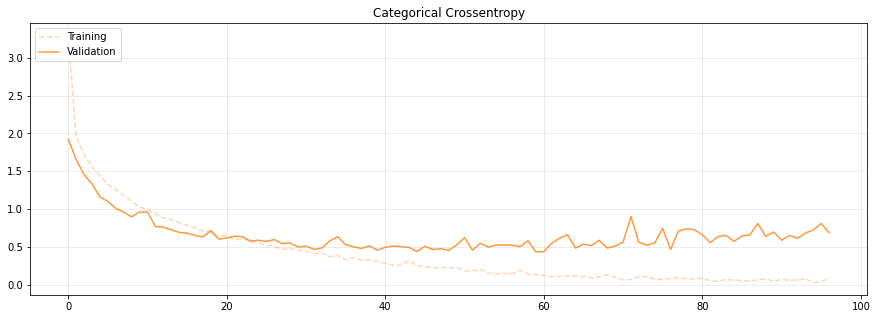

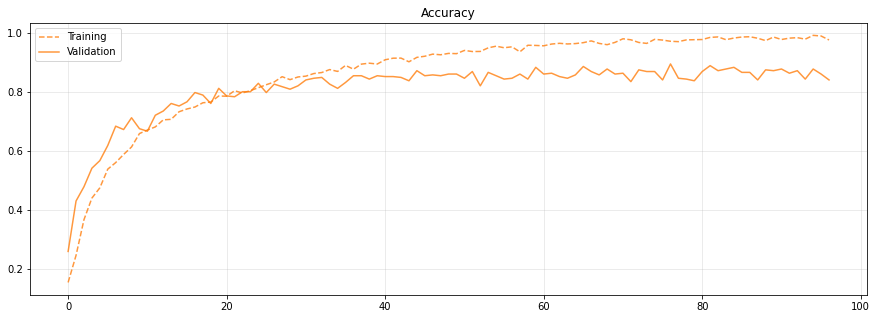

In [ ]:
import matplotlib.pyplot as plt
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()